<a href="https://colab.research.google.com/github/RanjKsan/Cyberbullying-detection-using-Transformer-model-and-XAI/blob/main/ALBERT%20and%20XLNET%20with%20LIME%20and%20SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

c7d144cd8b1cfb21fcd3776fa18a0686077060b9

ALBERT

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import AutoTokenizer

# Load the dataset
df = pd.read_csv("/content/cyberbullying_tweets.csv")  # Replace with your dataset path

# Step 2: Split the dataset into features (X) and target labels (y)
X = df["tweet_text"]
y = df["cyberbullying_type"]

# Step 3: Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 4: Encode the target labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
from torch.utils.data import Dataset

# Define a custom dataset class
class CyberbullyingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# Tokenizer for ALBERT
tokenizer_albert = AutoTokenizer.from_pretrained('albert-base-v2')

# Create the datasets
train_dataset = CyberbullyingDataset(X_train, y_train_encoded, tokenizer_albert)
val_dataset = CyberbullyingDataset(X_val, y_val_encoded, tokenizer_albert)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(axis=-1)  # Get the predicted class labels
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [ ]:
from transformers import AlbertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import gc

def clear_memory():
    torch.cuda.empty_cache()  # Empty the GPU cache
    gc.collect()  # Collect garbage

# Load the ALBERT model
model_albert = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=len(label_encoder.classes_))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_albert.to(device)

# Define training arguments for ALBERT
training_args_albert = TrainingArguments(
    output_dir='./results_albert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",  # Ensure evaluation happens after every epoch
    save_strategy="epoch",       # Save the model after every epoch, matching the evaluation strategy
    logging_dir='./logs_albert',
    logging_steps=10,
    load_best_model_at_end=True
)

# Define the Trainer
trainer_albert = Trainer(
    model=model_albert,
    args=training_args_albert,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the ALBERT model
trainer_albert.train()

# Clear memory after training
clear_memory()


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chaennie1880 (chaennie1880-c) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
pip install lime shap matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9875dfc6816920097e8fd18c27b98a65ab58fbd737804a0e04511530fb508b60
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


**LIME + ALBERT**

🔷 LIME Explanation for ALBERT Model 🔷


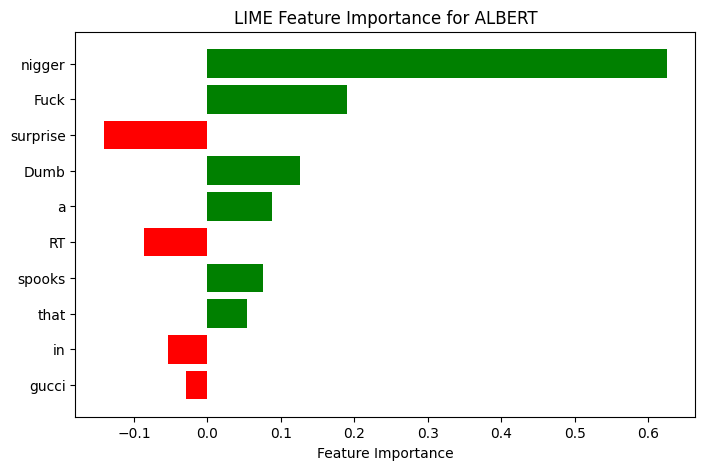

Probability Scores for each class:
age: 0.0000
ethnicity: 0.9998
gender: 0.0000
not_cyberbullying: 0.0000
other_cyberbullying: 0.0000
religion: 0.0000

Local Explanation (word contributions):
  nigger: Positive (0.6258)
  Fuck: Positive (0.1901)
  surprise: Negative (-0.1413)
  Dumb: Positive (0.1254)
  a: Positive (0.0878)
  RT: Negative (-0.0868)
  spooks: Positive (0.0751)
  that: Positive (0.0542)
  in: Negative (-0.0530)
  gucci: Negative (-0.0288)


In [ ]:
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt # Import the matplotlib library
from IPython.display import display, HTML

def explain_with_lime_albert(model, tokenizer, text_sample):
    """
    Generate LIME explanations for a given text sample using the ALBERT model.
    """
    class_names = label_encoder.classes_
    explainer = LimeTextExplainer(class_names=class_names)

    def predict_fn(texts):
        inputs = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        return torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

    explanation = explainer.explain_instance(
        text_sample,
        predict_fn,
        num_features=10,
        num_samples=100
    )

    # Plot feature importance
    weights = dict(explanation.as_list())
    words = list(weights.keys())
    values = list(weights.values())

    plt.figure(figsize=(8, 5))
    plt.barh(words, values, color=['green' if v > 0 else 'red' for v in values])
    plt.xlabel("Feature Importance")
    plt.title("LIME Feature Importance for ALBERT")
    plt.gca().invert_yaxis()
    plt.show()

    # Print probability scores
    probabilities = predict_fn([text_sample])[0]
    print("Probability Scores for each class:")
    for i, label in enumerate(class_names):
        print(f"{label}: {probabilities[i]:.4f}")

    # Print local explanation
    print("\nLocal Explanation (word contributions):")
    for word, weight in weights.items():
        contribution = "Positive" if weight > 0 else "Negative"
        print(f"  {word}: {contribution} ({weight:.4f})")

    # Display highlighted HTML text
    display(HTML(explanation.as_html()))

    # ✅ Return explanation so it can be used later
    return explanation

# Example usage
sample_text = X_val.iloc[5]
print("🔷 LIME Explanation for ALBERT Model 🔷")
explanation = explain_with_lime_albert(model_albert, tokenizer_albert, sample_text)
clear_memory()

In [ ]:
target_label = explanation.available_labels()[0]

# 1️⃣ Intercept & Feature Contributions
print(f"Intercept for label {target_label}: {explanation.intercept[target_label]:.4f}\n")
print(f"Feature Contributions for label {target_label}:")
# explanation.local_exp is a dict mapping label index to list of (feature_index, weight) tuples.
# For text explanations, the "feature_index" is actually the word (as a string) when using LimeTextExplainer.
for word, weight in explanation.local_exp[target_label]:
    print(f"  {word}: {weight:.4f}")

# 2️⃣ Local Prediction
# The local prediction is the sum of the intercept and the contributions.
local_prediction = explanation.intercept[target_label] + sum(weight for _, weight in explanation.local_exp[target_label])
print(f"\nLocal Prediction (Intercept + Sum of Feature Contributions): {local_prediction:.4f}")

# 3️⃣ Local Fidelity (R²)
# If your LIME Explanation object computed a fidelity score, it is usually stored in 'explanation.score'
if hasattr(explanation, "score") and explanation.score is not None:
    print(f"\nLocal Fidelity (R²): {explanation.score:.4f}")
else:
    print("\nLocal Fidelity (R²) is not directly available in this explanation object.")
clear_memory()

Intercept for label 1: 0.2024

Feature Contributions for label 1:
  10: 0.6258
  15: 0.1901
  6: -0.1413
  22: 0.1254
  5: 0.0878
  0: -0.0868
  23: 0.0751
  7: 0.0542
  13: -0.0530
  20: -0.0288

Local Prediction (Intercept + Sum of Feature Contributions): 1.0510

Local Fidelity (R²): 0.8330


**SHAP + ALBERT**

PartitionExplainer explainer: 11it [00:16,  2.72s/it]


🔷 SHAP Force Plot for the first sample:


🔷 SHAP Bar Plot of mean absolute feature importance:


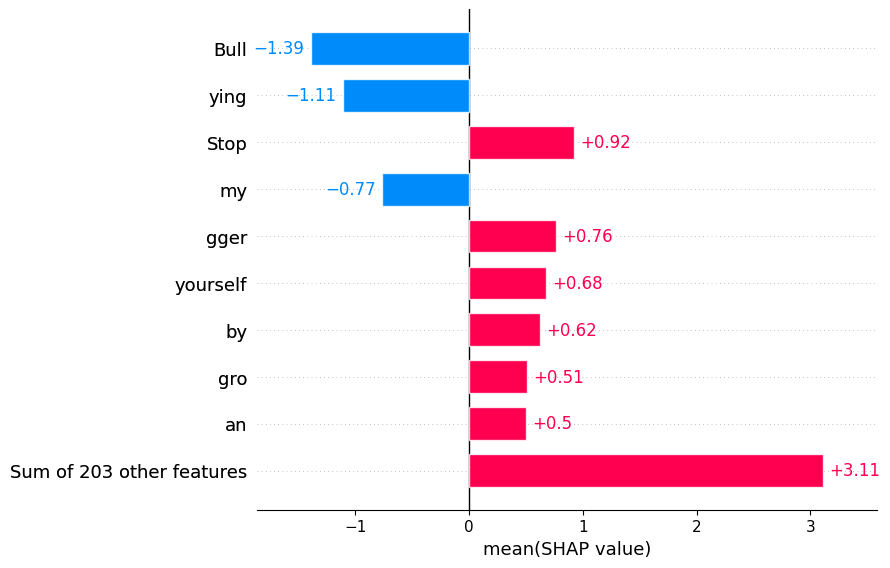

In [ ]:
import shap

def predictor_albert(texts):
    """
    SHAP prediction function for ALBERT. Takes a list of texts and returns model logits.

    Args:
        texts: List of text strings.

    Returns:
        Numpy array of logits.
    """
    # Ensure texts is a list and all elements are strings
    if isinstance(texts, str):
        texts = [texts]
    texts = [str(text) for text in texts]  # Convert all elements to strings

    encodings = tokenizer_albert(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model_albert(input_ids, attention_mask=attention_mask)

    return outputs.logits.cpu().numpy()

# Initialize SHAP explainer with a text masker
explainer = shap.Explainer(
    predictor_albert,
    masker=shap.maskers.Text(tokenizer_albert),
    output_names=label_encoder.classes_.tolist()
)

# Select a sample of texts to explain (adjust sample size as needed)
sample_texts = X_val.sample(n=10, random_state=42).tolist()

# Calculate SHAP values for the sample texts
shap_values = explainer(sample_texts)

# Visualization 1: Force plot for the first sample
print("🔷 SHAP Force Plot for the first sample:")
shap.plots.text(shap_values[0])
plt.show()

# Visualization 2: Bar plot of mean absolute SHAP values
print("🔷 SHAP Bar Plot of mean absolute feature importance:")
shap.plots.bar(shap_values.mean(0)[:, 1])
plt.show()

# Optionally clear GPU memory after execution
torch.cuda.empty_cache()


In [ ]:
import numpy as np
import shap
import torch
import random

def compute_shap_fidelity_albert(explainer, model, tokenizer, texts, top_k=5):
    """
    Computes fidelity score for SHAP explanations on an ALBERT model.

    Parameters:
        explainer (shap.Explainer): SHAP explainer object.
        model (torch.nn.Module): Trained ALBERT model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for ALBERT.
        texts (list): List of texts (from dataset) to compute fidelity scores.
        top_k (int): Number of top important tokens to mask.

    Returns:
        float: Average fidelity score over all samples.
    """
    fidelity_scores = []

    for text in texts:
        # Tokenize input
        inputs = tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        # Get original prediction probability
        with torch.no_grad():
            logits = model(input_ids, attention_mask=attention_mask).logits
            orig_pred_prob = torch.softmax(logits, dim=-1).max().item()  # Max probability class

        # Compute SHAP values
        shap_values = explainer([text])

        # Extract absolute SHAP values per token
        token_shap_values = np.abs(shap_values.values[0])  # Shape: (seq_len, num_classes)
        token_importance = token_shap_values.sum(axis=1)  # Sum across classes for each token

        # Get top-k important tokens
        top_k_indices = np.argsort(token_importance)[-top_k:]

        # Mask top-k tokens by replacing them with [MASK]
        masked_input_ids = input_ids.clone()
        for idx in top_k_indices:
            masked_input_ids[0, idx] = tokenizer.mask_token_id

        # Get prediction on masked input
        with torch.no_grad():
            masked_logits = model(input_ids=masked_input_ids, attention_mask=attention_mask).logits
            masked_pred_prob = torch.softmax(masked_logits, dim=-1).max().item()

        # Compute fidelity score
        fidelity_score = 1 - abs(orig_pred_prob - masked_pred_prob) / orig_pred_prob
        fidelity_scores.append(fidelity_score)

    # Compute average fidelity score across all samples
    avg_fidelity_score = np.mean(fidelity_scores)

    return round(avg_fidelity_score, 4)


# Select a subset of validation data to compute fidelity scores (reduce size for efficiency)
sample_texts = random.sample(X_val.tolist(), 40)

# Compute Fidelity Score for ALBERT
fidelity_score_albert = compute_shap_fidelity_albert(explainer, model_albert, tokenizer_albert, sample_texts)
print("Average SHAP Fidelity Score for ALBERT:", fidelity_score_albert)
clear_memory()

Average SHAP Fidelity Score for ALBERT: 0.7911


**XLNET**

In [ ]:
pip install transformers torch scikit-learn pandas


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("/content/cyberbullying_tweets.csv")  # Replace with your dataset path
df = df[['tweet_text', 'cyberbullying_type']]

In [ ]:
# Encode Labels
label_encoder = LabelEncoder()
df['cyberbullying_type'] = label_encoder.fit_transform(df['cyberbullying_type'])
num_labels = len(label_encoder.classes_)

In [ ]:
# Split Dataset
X_train, X_temp, y_train, y_temp = train_test_split(df['tweet_text'], df['cyberbullying_type'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# Define Dataset Class
class CyberbullyingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [ ]:
# Initialize Tokenizer and Dataset
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
train_dataset = CyberbullyingDataset(X_train, y_train, tokenizer)
val_dataset = CyberbullyingDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)
model.to(device)

# Define Optimizer and Loss
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import gc

In [ ]:
def clear_memory():
    torch.cuda.empty_cache()  # Empty the GPU cache
    gc.collect()  # Collect garbage

In [ ]:
# Training Function
def train_epoch(model, data_loader, optimizer, loss_fn, device):
    model.train()
    total_loss, total_correct = 0, 0
    preds, true_labels = [], []

    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        preds.extend(logits.argmax(dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average="weighted")
    accuracy = accuracy_score(true_labels, preds)

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset), precision, recall, f1, accuracy

# Evaluation Function
def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss, total_correct = 0, 0
    preds, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            total_correct += (logits.argmax(dim=1) == labels).sum().item()
            preds.extend(logits.argmax(dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average="weighted")
    accuracy = accuracy_score(true_labels, preds)

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset), precision, recall, f1, accuracy

# Training and Validation
epochs = 1
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train
    train_loss, train_acc, train_precision, train_recall, train_f1, train_accuracy = train_epoch(
        model, train_loader, optimizer, loss_fn, device
    )
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")

    # Validate
    val_loss, val_acc, val_precision, val_recall, val_f1, val_accuracy = eval_model(
        model, val_loader, loss_fn, device
    )
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")


Epoch 1/1
Train Loss: 0.4720, Train Accuracy: 0.8125, Precision: 0.8145, Recall: 0.8125, F1: 0.8124
Validation Loss: 0.3786, Validation Accuracy: 0.8588, Precision: 0.8627, Recall: 0.8588, F1: 0.8577


In [ ]:
clear_memory()

In [ ]:
!pip install lime

**LIME + XLNet**


🔷 **LIME Explanation for XLNet** 🔷


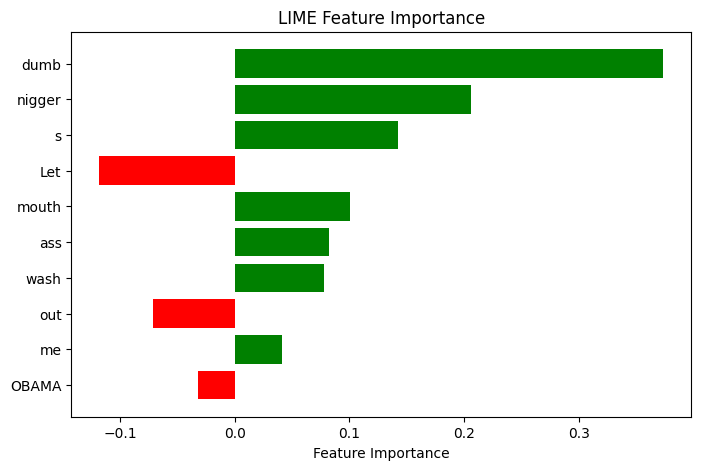

age: 0.0001
ethnicity: 0.9993
gender: 0.0000
not_cyberbullying: 0.0002
other_cyberbullying: 0.0001
religion: 0.0003

🔹 Local Explanation:
  dumb: 🟢 Positive (0.3733)
  nigger: 🟢 Positive (0.2057)
  s: 🟢 Positive (0.1427)
  Let: 🔴 Negative (-0.1180)
  mouth: 🟢 Positive (0.1002)
  ass: 🟢 Positive (0.0820)
  wash: 🟢 Positive (0.0775)
  out: 🔴 Negative (-0.0714)
  me: 🟢 Positive (0.0410)
  OBAMA: 🔴 Negative (-0.0323)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
from IPython.display import display, HTML

# Function to apply LIME for XLNet model
def explain_with_lime_XLNet(model, tokenizer, text_sample):
    """
    Apply LIME explanation on a given text for the XLNet model.

    Args:
        model: XLNetForSequenceClassification model
        tokenizer: XLNet tokenizer
        text_sample: The text sample to explain

    Returns:
        None (Displays visualizations)
    """
    class_names = label_encoder.classes_
    explainer = LimeTextExplainer(class_names=class_names)

    # Define prediction function for LIME
    def predict_fn(texts):
        inputs = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        return torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

    # Generate LIME explanation
    explanation_XLNet = explainer.explain_instance(
        text_sample,
        predict_fn,
        num_features=10,
        num_samples=100
    )

    # 1️⃣ **Bar Plot: Feature Importance**
    weights = dict(explanation_XLNet.as_list())
    words = list(weights.keys())
    values = list(weights.values())

    plt.figure(figsize=(8, 5))
    plt.barh(words, values, color=['green' if v > 0 else 'red' for v in values])
    plt.xlabel("Feature Importance")
    plt.title("LIME Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

    # 2️⃣ **Probability Scores for Each Class**
    probabilities = predict_fn([text_sample])[0]
    for i, label in enumerate(class_names):
        print(f"{label}: {probabilities[i]:.4f}")

    # 3️⃣ **Local Explanation (Positive & Negative Contributions)**
    print("\n🔹 Local Explanation:")
    for word, weight in weights.items():
        print(f"  {word}: {'🟢 Positive' if weight > 0 else '🔴 Negative'} ({weight:.4f})")

    # Display highlighted HTML text
    display(HTML(explanation_XLNet.as_html()))

    # 4️⃣ **Highlighted Text (HTML)**
    return explanation_XLNet

# Sample text from validation set
sample_text = X_val.iloc[0]

# Apply LIME for XLNet
print("\n🔷 **LIME Explanation for XLNet** 🔷")
explanation_XLNet=explain_with_lime_XLNet(model, tokenizer, sample_text)
clear_memory()


**LIME METRICS**

In [ ]:
target_label = explanation_XLNet.available_labels()[0]

# 1️⃣ Intercept & Feature Contributions
print(f"Intercept for label {target_label}: {explanation_XLNet.intercept[target_label]:.4f}\n")
print(f"Feature Contributions for label {target_label}:")
# explanation.local_exp is a dict mapping label index to list of (feature_index, weight) tuples.
# For text explanations, the "feature_index" is actually the word (as a string) when using LimeTextExplainer.
for word, weight in explanation_XLNet.local_exp[target_label]:
    print(f"  {word}: {weight:.4f}")

# 2️⃣ Local Prediction
# The local prediction is the sum of the intercept and the contributions.
local_prediction = explanation_XLNet.intercept[target_label] + sum(weight for _, weight in explanation_XLNet.local_exp[target_label])
print(f"\nLocal Prediction (Intercept + Sum of Feature Contributions): {local_prediction:.4f}")

# 3️⃣ Local Fidelity (R²)
# If your LIME Explanation object computed a fidelity score, it is usually stored in 'explanation.score'
if hasattr(explanation_XLNet, "score") and explanation_XLNet.score is not None:
    print(f"\nLocal Fidelity (R²): {explanation_XLNet.score:.4f}")
else:
    print("\nLocal Fidelity (R²) is not directly available in this explanation object.")
clear_memory()

Intercept for label 1: 0.2706

Feature Contributions for label 1:
  16: 0.3733
  8: 0.2057
  9: 0.1427
  0: -0.1180
  4: 0.1002
  17: 0.0820
  2: 0.0775
  5: -0.0714
  1: 0.0410
  15: -0.0323

Local Prediction (Intercept + Sum of Feature Contributions): 1.0714

Local Fidelity (R²): 0.7517


**SHAP + XLNet**

PartitionExplainer explainer: 51it [01:49,  2.29s/it]


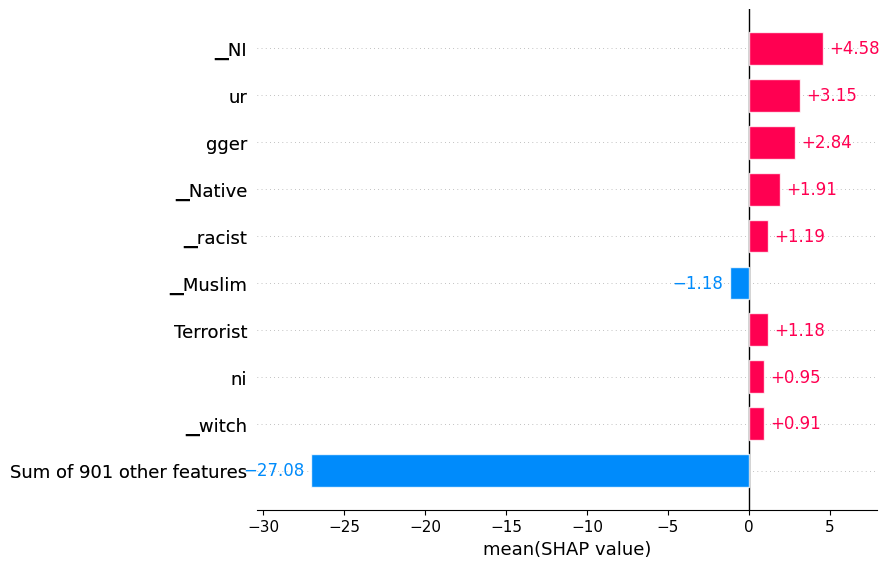

In [ ]:
import shap

# Create a prediction function compatible with SHAP
def predictor(texts):
    # Ensure input is a list of strings
    if isinstance(texts, str):
        texts = [texts]

    # Tokenize and process input
    encodings = tokenizer(
        [str(text) for text in texts],
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    # Move tensors to the same device as the model
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    # Disable gradient calculation for efficiency
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Return model logits
    return outputs.logits.cpu().numpy()

# Initialize SHAP explainer with correct masker
explainer = shap.Explainer(
    predictor,
    masker=shap.maskers.Text(tokenizer),
    output_names=label_encoder.classes_.tolist()
)

# Select a sample of texts to explain (reduce sample size if SHAP is too slow)
sample_texts = X_val.sample(n=50, random_state=42).tolist()

# Calculate SHAP values
shap_values = explainer(sample_texts)

# Visualization 1: Force plot for individual predictions
shap.plots.text(shap_values[0])  # Show explanation for first sample

# Visualization 2: Bar plot of mean absolute SHAP values
shap.plots.bar(shap_values.mean(0)[:, 1])

# Clear GPU memory
torch.cuda.empty_cache()


**SHAP METRICS**

In [ ]:
import numpy as np
import shap
import torch
import random

def compute_shap_fidelity_xlnet(explainer, model, tokenizer, texts, top_k=5):
    """
    Computes fidelity score for SHAP explanations on an XLNet model.

    Parameters:
        explainer (shap.Explainer): SHAP explainer object.
        model (torch.nn.Module): Trained XLNet model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for XLNet.
        texts (list): List of texts (from dataset) to compute fidelity scores.
        top_k (int): Number of top important tokens to mask.

    Returns:
        float: Average fidelity score over all samples.
    """
    fidelity_scores = []

    for text in texts:
        # Tokenize input
        inputs = tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        # Get original prediction probability
        with torch.no_grad():
            logits = model(input_ids, attention_mask=attention_mask).logits
            orig_pred_prob = torch.softmax(logits, dim=-1).max().item()  # Max probability class

        # Compute SHAP values
        shap_values = explainer([text])

        # Extract absolute SHAP values per token
        token_shap_values = np.abs(shap_values.values[0])  # Shape: (seq_len, num_classes)
        token_importance = token_shap_values.sum(axis=1)  # Sum across classes for each token

        # Get top-k important tokens
        top_k_indices = np.argsort(token_importance)[-top_k:]

        # Mask top-k tokens by replacing them with [MASK]
        masked_input_ids = input_ids.clone()
        for idx in top_k_indices:
            masked_input_ids[0, idx] = tokenizer.mask_token_id

        # Get prediction on masked input
        with torch.no_grad():
            masked_logits = model(input_ids=masked_input_ids, attention_mask=attention_mask).logits
            masked_pred_prob = torch.softmax(masked_logits, dim=-1).max().item()

        # Compute fidelity score
        fidelity_score = 1 - abs(orig_pred_prob - masked_pred_prob) / orig_pred_prob
        fidelity_scores.append(fidelity_score)

    # Compute average fidelity score across all samples
    avg_fidelity_score = np.mean(fidelity_scores)

    return round(avg_fidelity_score, 4)


# Select a subset of validation data to compute fidelity scores (reduce size for efficiency)
sample_texts = random.sample(X_val.tolist(), 50)

# Compute Fidelity Score for XLNet
fidelity_score_xlnet = compute_shap_fidelity_xlnet(explainer, model, tokenizer, sample_texts)
print("Average SHAP Fidelity Score for XLNet:", fidelity_score_xlnet)
clear_memory()

Average SHAP Fidelity Score for XLNet: 0.7699
